# Executive Summary

The purpose of this project is to prepare the infrastructure for a service that delivers assessments. This involves the following tasks:
- publishing and consuming messages with Kafka 
- using Spark to transform messages 
- landing messages within HDFS

The file, "assessment-attempts-20180128-121051-nested.json", is provided and upon exploration, the data shows the following issues:
 - binary values 
 - a nested array (i.e. nested lists and nested dictionaries)

We seek to answer the following business questions: 
1. How many assessments are in the dataset?
2. What is the least common course taken? And the most common?
3. What is the average assessment score for the top 5 most popular courses?

We cast the raw assessments data as a string to address the binary values, and then we unroll the JSON file to answer the third business question above. After we completed these transformations, we were able to answer the above business questions: 

1. 3242 assessments are in the dataset

2. Native Web Apps for Android, Learning to Visualize Data with D3.js, Nulls, Three-valued Logic and Missing Information, and Operating Red Hat Enterprise Linux Servers are the least popular courses, with only one single assessment for each course. Learning Git is the most popular course with 390 assessments from distinct users.  

3. The top 5 most popular courses had the following average assessment scores: 
     - Learning Git: 67.6142131979696 
     - Introduction to Python: 56.66666666666664
     - Introduction to Java 8: 87.59493670886073
     - Intermediate Python Programming: 51.26582278481012
     - Learning to Program with R: 54.46428571428569

Finally, all dataframes were published to HDFS. 

## Part 1: Linux Commands - Setup 

### The following commands are executed once:

##### set up project directory and branches

ls 

cd w205

git clone https://github.com/mids-w205-martin-mims/project-2-edakavlakoglu.git

cd project-2-edakavlakoglu

git branch assignment

git checkout assignment


##### copy yml file in project directory 


cp ~/w205/course-content/08-Querying-Data/docker-compose.yml .


##### modify yml file for juptyer notebook then check modifications

cat docker-compose.yml


##### download assessments file


curl -L -o assessment-attempts-20180128-121051-nested.json https://goo.gl/ME6hjp


### The following commands are executed every time I start a cluster:

##### check for old containers 

docker ps -a 

##### start up cluster 

docker-compose up -d
docker-compose ps

##### execute a bash shell in spark container
docker-compose exec spark bash

##### create symbolic link in spark container 
ln -s /w205 w205

##### exit container 
exit 

##### run a jupyter notebook with pyspark kernel 

docker-compose exec spark env PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --no-browser --port 8888 --ip 0.0.0.0 --allow-root' pyspark

##### check jupyter notebook exists 
 
 ls

##### create topic assessments 

 docker-compose exec kafka \
  kafka-topics \
    --create \
    --topic assessments \
    --partitions 1 \
    --replication-factor 1 \
    --if-not-exists \
    --zookeeper zookeeper:32181

##### publish assessments to kafka

docker-compose exec mids bash -c "cat /w205/project-2-edakavlakoglu/assessment-attempts-20180128-121051-nested.json | jq '.[]' -c | kafkacat -P -b kafka:29092 -t assessments"

##### check assessments published to kafka 

docker-compose exec mids bash -c "kafkacat -C -b kafka:29092 -t assessments -o beginning -e"


## Part 2: Exploring JSON file via JQ and Spark SQL

In [282]:
import json
import pprint
from pyspark.sql import Row 

In [283]:
#check if spark object is there 
spark

In [284]:
# check if sc is there
sc

<SparkContext master=local[*] appName=PySparkShell>

In [285]:
#read assessments from kafka

raw_assessments = spark \
  .read \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:29092") \
  .option("subscribe","assessments") \
  .option("startingOffsets", "earliest") \
  .option("endingOffsets", "latest") \
  .load() 

In [286]:
#cache to cut back on warnings 
raw_assessments.cache()

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [287]:
#print schema
raw_assessments.printSchema()

#note: value is in binary format

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [288]:
#show raw assessments data
raw_assessments.show(5)

+----+--------------------+-----------+---------+------+--------------------+-------------+
| key|               value|      topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-----------+---------+------+--------------------+-------------+
|null|[7B 22 6B 65 65 6...|assessments|        0|     0|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     1|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     2|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     3|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     4|1969-12-31 23:59:...|            0|
+----+--------------------+-----------+---------+------+--------------------+-------------+
only showing top 5 rows



In [289]:
#Convert the `value` as string
    assessments = raw_assessments.select(raw_assessments.value.cast('string'))

IndentationError: unexpected indent (<ipython-input-289-8363a431a3a1>, line 2)

In [ ]:
#check that data is no longer in binary format
assessments.show(5)

In [ ]:
extracted_assessments = assessments.rdd.map(lambda x: json.loads(x.value)).toDF()

In [ ]:
#print schema
extracted_assessments.printSchema()

In [ ]:
#didn't run, but can use pretty print instead to examine nested data
cat assessment-attempts-20180128-121051-nested.json | jq '.[]' -c | head -1 | jq .

In [290]:
#view json data using pretty print

with open("assessment-attempts-20180128-121051-nested.json","r") as json_file:
    json_data = json.load(json_file)

print(json.dumps(json_data[0], indent=1))

{
 "keen_timestamp": "1516717442.735266",
 "max_attempts": "1.0",
 "started_at": "2018-01-23T14:23:19.082Z",
 "base_exam_id": "37f0a30a-7464-11e6-aa92-a8667f27e5dc",
 "user_exam_id": "6d4089e4-bde5-4a22-b65f-18bce9ab79c8",
 "sequences": {
  "questions": [
   {
    "user_incomplete": true,
    "user_correct": false,
    "options": [
     {
      "checked": true,
      "at": "2018-01-23T14:23:24.670Z",
      "id": "49c574b4-5c82-4ffd-9bd1-c3358faf850d",
      "submitted": 1,
      "correct": true
     },
     {
      "checked": true,
      "at": "2018-01-23T14:23:25.914Z",
      "id": "f2528210-35c3-4320-acf3-9056567ea19f",
      "submitted": 1,
      "correct": true
     },
     {
      "checked": false,
      "correct": true,
      "id": "d1bf026f-554f-4543-bdd2-54dcf105b826"
     }
    ],
    "user_submitted": true,
    "id": "7a2ed6d3-f492-49b3-b8aa-d080a8aad986",
    "user_result": "missed_some"
   },
   {
    "user_incomplete": false,
    "user_correct": false,
    "options": [
   

In [291]:
#create a temp table for assessments dataframe to execute Spark SQL  
extracted_assessments.registerTempTable('assessments')
spark.sql("select keen_id from assessments limit 5").show()

+--------------------+
|             keen_id|
+--------------------+
|5a6745820eb8ab000...|
|5a674541ab6b0a000...|
|5a67999d3ed3e3000...|
|5a6799694fc7c7000...|
|5a6791e824fccd000...|
+--------------------+



## Part 3: Answering Business Questions Using Spark SQL 

#### 1. How many assessments are in the dataset?

In [292]:
spark.sql("select count(distinct keen_id) as assessment_count from assessments limit 5").show()

+----------------+
|assessment_count|
+----------------+
|            3242|
+----------------+



#### 2. What is the least common course taken? And the most common?

In [293]:
#least popular courses
spark.sql("select exam_name as course, count(distinct user_exam_id) from assessments group by exam_name order by 2 asc").show(5, False)

+-------------------------------------------------+----------------------------+
|course                                           |count(DISTINCT user_exam_id)|
+-------------------------------------------------+----------------------------+
|Native Web Apps for Android                      |1                           |
|Learning to Visualize Data with D3.js            |1                           |
|Nulls, Three-valued Logic and Missing Information|1                           |
|Operating Red Hat Enterprise Linux Servers       |1                           |
|Learning Spring Programming                      |2                           |
+-------------------------------------------------+----------------------------+
only showing top 5 rows



In [294]:
#most popular course
spark.sql("select exam_name as course, count(distinct user_exam_id) from assessments group by exam_name order by 2 desc").show(1)

+------------+----------------------------+
|      course|count(DISTINCT user_exam_id)|
+------------+----------------------------+
|Learning Git|                         390|
+------------+----------------------------+
only showing top 1 row



#### 3. What is the average assessment score for the top 5 most popular courses?

In [295]:
def extract_assessment_dtls_from_json(row):
    assessments = json.loads(row.value)
    assessment_scores = []
    
    if "sequences" in assessments.keys():
        if "counts" in assessments["sequences"].keys():
            if "correct" in assessments["sequences"]["counts"].keys() and "total" in assessments["sequences"]["counts"].keys():
                score_row = {"course": assessments["exam_name"],
                             "user_id": assessments["user_exam_id"],
                             "correct": assessments["sequences"]["counts"]["correct"],
                             "total": assessments["sequences"]["counts"]["total"], 
                             "score": assessments["sequences"]["counts"]["correct"]/assessments["sequences"]["counts"]["total"]
                            }
        
            assessment_scores.append(Row(**score_row))
        
    return assessment_scores

assessmnt_dtls = assessments.rdd.flatMap(extract_assessment_dtls_from_json).toDF()



In [296]:
assessmnt_dtls.show(5)

+-------+--------------------+-----+-----+--------------------+
|correct|              course|score|total|             user_id|
+-------+--------------------+-----+-----+--------------------+
|      2|Normal Forms and ...|  0.5|    4|6d4089e4-bde5-4a2...|
|      1|Normal Forms and ...| 0.25|    4|2fec1534-b41f-441...|
|      3|The Principles of...| 0.75|    4|8edbc8a8-4d26-429...|
|      2|The Principles of...|  0.5|    4|c0ee680e-8892-4e6...|
|      3|Introduction to B...| 0.75|    4|e4525b79-7904-405...|
+-------+--------------------+-----+-----+--------------------+
only showing top 5 rows



In [297]:
assessmnt_dtls.registerTempTable('assessment_scores')

In [298]:
#average score for Learning Git course only
spark.sql("select avg(score)*100 as average_score from assessment_scores where course = 'Learning Git'").show()

+----------------+
|   average_score|
+----------------+
|67.6142131979696|
+----------------+



In [299]:
#average scores for top 5 most popular courses
spark.sql("select course, avg(score)*100 as average_score from assessment_scores group by 1 order by count(user_id) desc").show(5, False)

+-------------------------------+-----------------+
|course                         |average_score    |
+-------------------------------+-----------------+
|Learning Git                   |67.6142131979696 |
|Introduction to Python         |56.66666666666664|
|Introduction to Java 8         |87.59493670886073|
|Intermediate Python Programming|51.26582278481012|
|Learning to Program with R     |54.46428571428569|
+-------------------------------+-----------------+
only showing top 5 rows



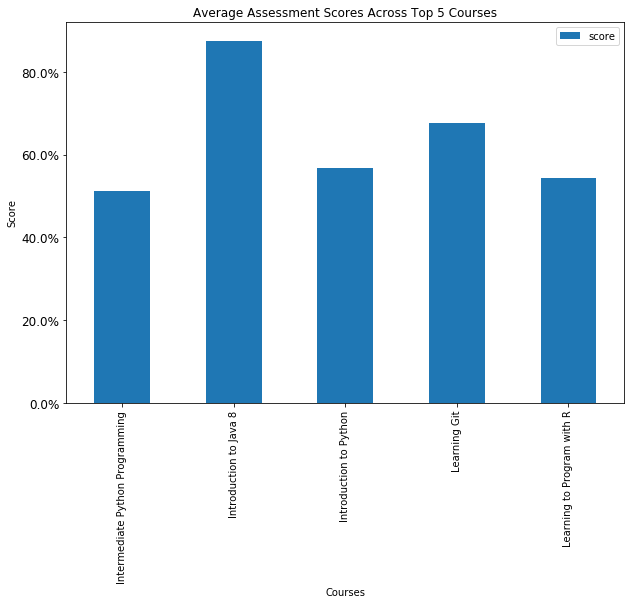

In [300]:
#include data visualization here 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick


# import seaborn as sns
top_5 = ['Learning Git', 'Introduction to Python', 'Introduction to Java 8', 'Intermediate Python Programming', 'Learning to Program with R']
df = assessmnt_dtls.toPandas()
df = df[df['course'].isin(top_5)] 
avg_scores = df[['score', 'course']].groupby('course').mean()
ax = avg_scores.plot(kind='bar', figsize = (10,7), title = "Average Assessment Scores Across Top 5 Courses")
ax.set_xlabel('Courses')
ax.set_ylabel('Score')
yvals = ax.get_yticks()
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=12)
plt.show()

## Part 4: Write to HDFS 

Write to Hadoop HDFS in parquet format to allow us to build a batch and serving layer. Repeat this command for all dataframes. 

In [301]:
assessments.write.parquet("/tmp/")

AnalysisException: 'path hdfs://cloudera/tmp already exists.;'

In [302]:
assessments.write.mode("overwrite").parquet("/tmp/assessments")

In [303]:
assessments.write.mode("overwrite").parquet("/tmp/extracted_assessments")

In [304]:
assessments.write.mode("overwrite").parquet("/tmp/assessmnt_dtls")

## Part 5: Linux Commands - Tear Down

##### check hadoop hdfs writes
docker-compose exec cloudera hadoop fs -ls /tmp/

docker-compose exec cloudera hadoop fs -ls /tmp/assessments/

docker-compose exec cloudera hadoop fs -ls /tmp/extracted_assessments/

docker-compose exec cloudera hadoop fs -ls /tmp/assessmnt_dtls

##### tear down cluster
docker-compose down